## Quantized CaffeNet
This IPython Notebook use the quantization layer to implement the fixed point version of `CaffeNet` [variant of ILSVRC 2012]

## 1. Setup and dataset prepared 
Prepare the essential packages (modules) for Caffe Library and the dataset for inference. 

In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (5, 5)          # medium images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = '../../'  # points to the root directory of caffe
sys.path.insert(0, caffe_root + 'python')

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.
from caffe import layers as L, params as P

# set CPU mode
caffe.set_mode_cpu()

# prepare the ILSVRC dataset
# path to the converted LMDB data 
# here we use the validation dataset
LMDB_filename = '/media/jingyang/0E3519FE0E3519FE/ilsvrc12_val_lmdb/'

# Load ImageNet labels to imagenet_labels
imagenet_label_file = caffe_root + '/data/ilsvrc12/synset_words.txt'
imagenet_labels = list(np.loadtxt(imagenet_label_file, str, delimiter='\t'))
assert len(imagenet_labels) == 1000

# transformer
# Define the preprocessing step for CaffeNet
from scipy.ndimage import zoom
mu = np.load(caffe_root + '/python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = zoom(mu, (1, 227./256, 227./256))
transformer = caffe.io.Transformer({'data': (1, 3, 227, 227)})
transformer.set_transpose('data', (2, 0, 1)) # move channel to outmost dimension
transformer.set_mean('data', mu)
transformer.set_raw_scale('data', 255.)
transformer.set_channel_swap('data', (2, 1, 0)) # RGB -> BGR

# mean data: accompanied by the Caffe
mean_file = caffe_root + 'data/ilsvrc12/imagenet_mean.binaryproto'

# pre-trained model
caffenet_weights = caffe_root + '/models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'

Setup the basic training parameters for CaffeNet.

In [2]:
batch_size = 10 # batch size for validation accuracy evaluation
iterations = 5 # number of iterations for validation accuracy evaluation 
                # the total number of images = batch_size * iterations

## 2. Running the Floating Point CaffeNet 
Floating point CaffeNet acts as a golden truth version of CaffeNet. It provides the baseline for the accuracy rate as well as the dynamic range of kernels and activations. 

Batch 0: Top-1 accuracy: 0.700000, Top-5 accuracy: 0.900000
Batch 1: Top-1 accuracy: 0.600000, Top-5 accuracy: 0.800000
Batch 2: Top-1 accuracy: 0.900000, Top-5 accuracy: 0.900000
Top-5 Predicted: [ 61 956 467  60  62]
Top-5 Predicted: [234 236 179 205 224]
Top-5 Predicted: [52 53 57 60 58]
Top-5 Predicted: [900 448 437 494 733]
Top-5 Predicted: [964 961 930 963 940]
Top-5 Predicted: [301 989 304 308 310]
Top-5 Predicted: [207 231 257 260 219]
Top-5 Predicted: [959 938 965 936 935]
Top-5 Predicted: [295 294 297 342 276]
Top-5 Predicted: [233 183 197 266 177]
Batch 3: Top-1 accuracy: 0.500000, Top-5 accuracy: 0.600000
Batch 4: Top-1 accuracy: 0.600000, Top-5 accuracy: 0.700000
Overall accuracy: Top-1: 0.660000; Top-5: 0.780000


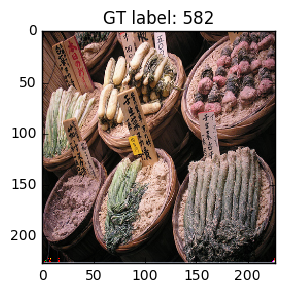

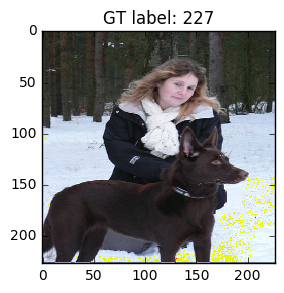

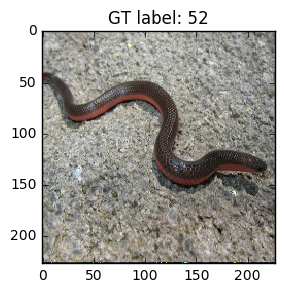

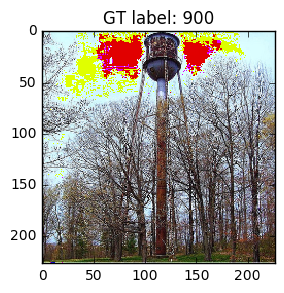

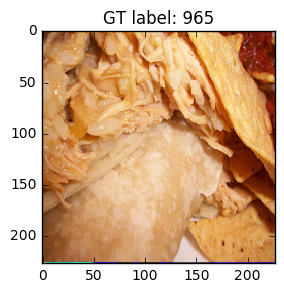

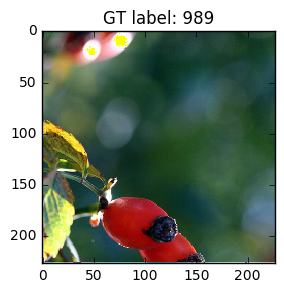

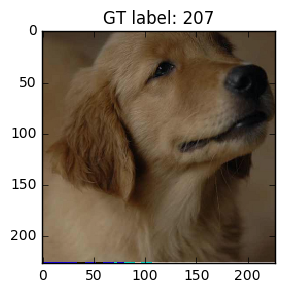

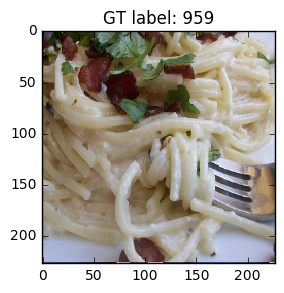

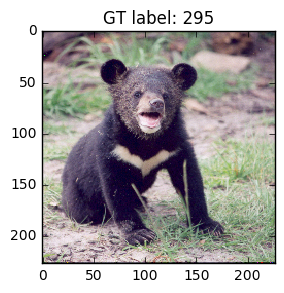

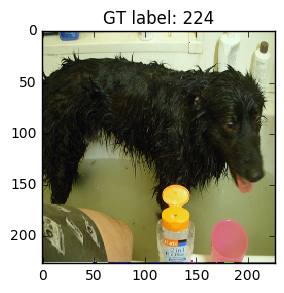

In [3]:
from caffenet_prototxt import caffenet

# filename for floating point caffenet
floating_point_caffenet_filename = 'floating_point_caffenet.prototxt'
# create input data layer for caffenet accuracy 
ilsvrc_data, ilsvrc_label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=LMDB_filename, ntop=2,
                    transform_param={'crop_size': 227, 'mirror': False, 'mean_file': mean_file})

# generate the prototxt file for CaffeNet definition
caffenet(ilsvrc_data, label=ilsvrc_label, train=False, num_classes=1000, classifier_name='fc8', 
         learn_all=False, filename=floating_point_caffenet_filename)

# create the floating point caffenet
floating_point_caffenet = None # workaround for sharing LMDB dataset
floating_point_caffenet = caffe.Net(floating_point_caffenet_filename, caffenet_weights, caffe.TEST)

# run the feedforward of floating point CaffeNet for validation accuracy evaluation
floating_point_acc = np.zeros((2, iterations)) # record the accuracy for each iteration
caffenet_blobs_range = {} # record the range of intermediate feature maps 
for k in floating_point_caffenet.blobs:
    if 'split' not in k:
        caffenet_blobs_range[k] = np.zeros((2, iterations)) # store min & max

for i in range(iterations):
    floating_point_caffenet.forward() # forward pass
    
    if i == 3:
        # show one batch result
        input_data = floating_point_caffenet.blobs['data'].data
        label_data = floating_point_caffenet.blobs['label'].data
        probs_data = floating_point_caffenet.blobs['probs'].data
        for idx in range(input_data.shape[0]): # over image idx
            top_5 = (-probs_data[idx]).argsort()[:5]
            print 'Top-5 Predicted: %s' % (str(top_5), )
            plt.figure(figsize=(3, 3))
            plt.imshow(transformer.deprocess('data', input_data[idx]))   
            plt.title('GT label: %d' % label_data[idx])
    
    for k in floating_point_caffenet.blobs:
        if 'split' not in k:
            caffenet_blobs_range[k][0, i] = floating_point_caffenet.blobs[k].data.min() # min value
            caffenet_blobs_range[k][1, i] = floating_point_caffenet.blobs[k].data.max() # max value
    floating_point_acc[0, i] = floating_point_caffenet.blobs['acc_top1'].data
    floating_point_acc[1, i] = floating_point_caffenet.blobs['acc_top5'].data
    print 'Batch %d: Top-1 accuracy: %f, Top-5 accuracy: %f' % (i, floating_point_acc[0, i],
                                                               floating_point_acc[1, i])

print 'Overall accuracy: Top-1: %f; Top-5: %f' % (floating_point_acc.mean(axis=1)[0],
                                                 floating_point_acc.mean(axis=1)[1])

- The range at each intermediate layer:
We need to record the range for layer-on quantized CaffeNet construction.

In [4]:
blobs_range = {}
blobs_name = []
print 'Min & Max values at each layer'
for k in floating_point_caffenet.blobs:
    if 'split' not in k:
        smallest = caffenet_blobs_range[k][0].min()
        largest = caffenet_blobs_range[k][1].max()
        blobs_range[k] = [smallest, largest] # record the range 
        print '- layer[%s]: min %f; max %f' % (k, smallest, largest)
        blobs_name.append(k)

Min & Max values at each layer
- layer[data]: min -130.189407; max 160.744446
- layer[label]: min 49.000000; max 989.000000
- layer[conv1]: min -2767.533203; max 2779.921631
- layer[relu1]: min 0.000000; max 2779.921631
- layer[pool1]: min 0.000000; max 2779.921631
- layer[norm1]: min 0.000000; max 138.697418
- layer[conv2]: min -599.630432; max 474.258698
- layer[relu2]: min 0.000000; max 474.258698
- layer[pool2]: min 0.000000; max 474.258698
- layer[norm2]: min 0.000000; max 138.725891
- layer[conv3]: min -392.206512; max 400.591278
- layer[relu3]: min 0.000000; max 400.591278
- layer[conv4]: min -242.303482; max 302.048737
- layer[relu4]: min 0.000000; max 302.048737
- layer[conv5]: min -194.317703; max 280.259247
- layer[relu5]: min 0.000000; max 280.259247
- layer[pool5]: min 0.000000; max 280.259247
- layer[fc6]: min -114.228371; max 63.336704
- layer[relu6]: min 0.000000; max 63.336704
- layer[fc7]: min -27.128517; max 25.637053
- layer[relu7]: min 0.000000; max 25.637053
- lay

- The range of each parameters

In [5]:
weights_range, biases_range = {}, {}
kernels_name = []
print 'Min & Max values of the parameters @ each layer'
for k, v in floating_point_caffenet.params.items():
    weights_range[k] = [v[0].data.min(), v[0].data.max()]
    biases_range[k] = [v[1].data.min(), v[1].data.max()]
    kernels_name.append(k)
    print '- kernels[%s]: weights [%f, %f]; biases [%f, %f]' % (k, v[0].data.min(), 
                                                               v[0].data.max(), v[1].data.min(),
                                                              v[1].data.max())
    
# remove the floating point caffent, otherwise sharing of LMDB is not allowed         
del floating_point_caffenet

Min & Max values of the parameters @ each layer
- kernels[conv1]: weights [-0.373572, 0.402661]; biases [-0.854293, 0.231814]
- kernels[conv2]: weights [-0.284751, 0.415510]; biases [0.957619, 1.034461]
- kernels[conv3]: weights [-0.185205, 0.512327]; biases [-0.103622, 0.093132]
- kernels[conv4]: weights [-0.142460, 0.353425]; biases [0.770084, 1.219321]
- kernels[conv5]: weights [-0.132628, 0.314808]; biases [0.623151, 1.741738]
- kernels[fc6]: weights [-0.035163, 0.048431]; biases [0.919630, 1.056938]
- kernels[fc7]: weights [-0.032089, 0.052134]; biases [0.741186, 1.260424]
- kernels[fc8]: weights [-0.044658, 0.067401]; biases [-0.351150, 0.425084]


## 3. Running the quantized CaffeNet based on the Quantization Scheme
We will generate the corresponding quantized CaffeNet with the quantization scheme determined above.  
- Basic setup for fixed point

In [6]:
# setup for the quantization layer
round_method = 'FLOOR' # round method 
round_strategy = 'AGGRESSIVE' # round strategy
bit_width = 8

# here assume simple uniform bit width of the feature map of 
# CaffeNet
blobs_bit_width = {}
for k in blobs_name:
    blobs_bit_width[k] = bit_width
        
# here assume simple unifrom bit width of kernels (weights & biases) of CaffeNet
kernels_bit_width = {}
for k in kernels_name:
    kernels_bit_width[k] = bit_width

- Construct the fixed point CaffeNet

In [7]:
from caffenet_prototxt import convert_to_quantization_param, quantized_caffenet

# convert the quantization schemes to quantization parameter format
blobs_quantization_params = convert_to_quantization_param(blobs_bit_width, blobs_range,
                                    round_method=round_method, round_strategy=round_strategy)

# filename for quantized caffenet
quantized_caffenet_filename = 'quantized_caffenet.prototxt'

# generate the prototxt file for CaffeNet definition
quantized_caffenet(ilsvrc_data, blobs_quantization_params, label=ilsvrc_label, 
                   train=False, num_classes=1000, classifier_name='fc8', 
                   learn_all=False, filename=quantized_caffenet_filename)

# load the quantized caffenet
quantized_caffenet_net = None # workaround for sharing LMDB
quantized_caffenet_net = caffe.Net(quantized_caffenet_filename, caffenet_weights, caffe.TEST)

# import fixed_point function
from fixed_point import *

# quantize the kernels (weights + biases)
for layer_name, param in quantized_caffenet_net.params.items():
    # quantized weights: param[0] 
    WFixedPoint = FixedPoint(weights_range[layer_name], kernels_bit_width[layer_name], 
                             round_method=round_method, round_strategy=round_strategy)
    param[0].data[...] = WFixedPoint.quantize(param[0].data)   
    
    # quantized biases: param[1]
    BFixedPoint = FixedPoint(biases_range[layer_name], kernels_bit_width[layer_name],
                            round_method=round_method, round_strategy=round_strategy)
    param[1].data[...] = BFixedPoint.quantize(param[1].data)

- Run the quantizated CaffeNet

Quantization Scheme with Bit Width 8
Batch 0: Top-1 accuracy: 0.400000, Top-5 accuracy: 0.500000
Batch 1: Top-1 accuracy: 0.400000, Top-5 accuracy: 0.700000
Batch 2: Top-1 accuracy: 0.100000, Top-5 accuracy: 0.600000
Top-5 Predicted: [60 66 61 62 76]
Top-5 Predicted: [197 214 179 205 234]
Top-5 Predicted: [52 53 60 58 65]
Top-5 Predicted: [448 733 704 863 437]
Top-5 Predicted: [964 961 930 935 885]
Top-5 Predicted: [989 957 971  90 122]
Top-5 Predicted: [265 260 266 267 191]
Top-5 Predicted: [959 965 923 415 909]
Top-5 Predicted: [276 294 295 275 179]
Top-5 Predicted: [266 903 221 265 183]
Batch 3: Top-1 accuracy: 0.300000, Top-5 accuracy: 0.500000
Batch 4: Top-1 accuracy: 0.300000, Top-5 accuracy: 0.800000
Overall accuracy: Top-1: 0.300000; Top-5: 0.620000


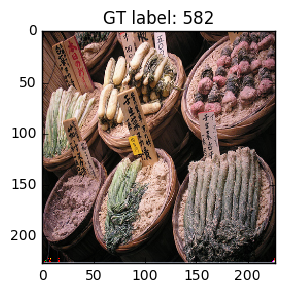

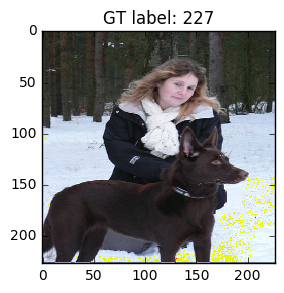

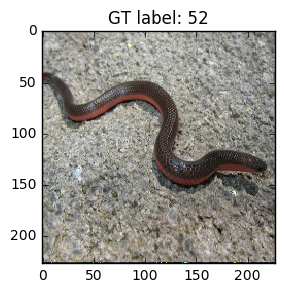

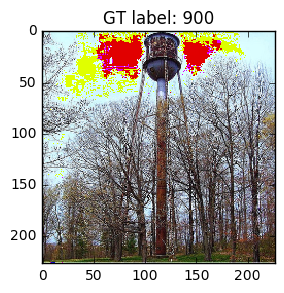

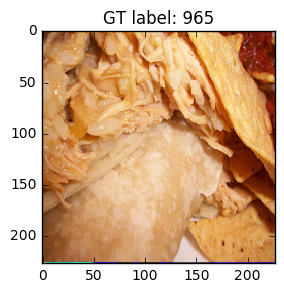

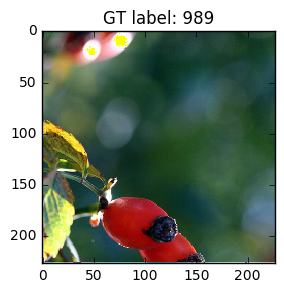

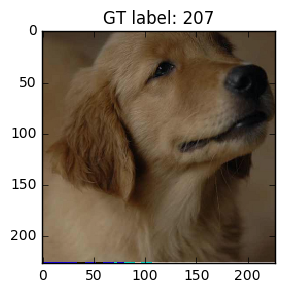

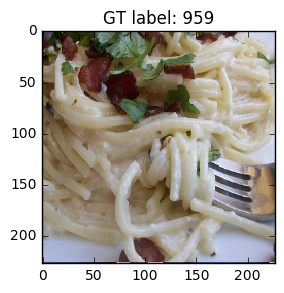

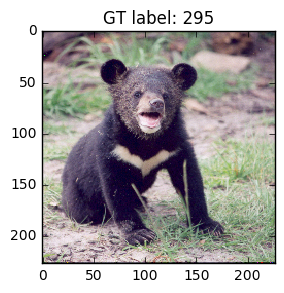

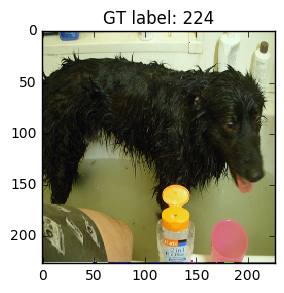

In [8]:
quantized_acc = np.zeros((2, iterations))

print 'Quantization Scheme with Bit Width %d' % (bit_width, )

for i in range(iterations):
    quantized_caffenet_net.forward() # forward pass
    
    if i == 3:
        # show one batch result
        input_data = quantized_caffenet_net.blobs['data'].data
        label_data = quantized_caffenet_net.blobs['label'].data
        probs_data = quantized_caffenet_net.blobs['probs'].data
        for idx in range(input_data.shape[0]): # over image idx
            top_5 = (-probs_data[idx]).argsort()[:5]
            print 'Top-5 Predicted: %s' % (str(top_5), )
            plt.figure(figsize=(3, 3))
            plt.imshow(transformer.deprocess('data', input_data[idx]))   
            plt.title('GT label: %d' % label_data[idx])

    quantized_acc[0, i] = quantized_caffenet_net.blobs['acc_top1'].data
    quantized_acc[1, i] = quantized_caffenet_net.blobs['acc_top5'].data
    print 'Batch %d: Top-1 accuracy: %f, Top-5 accuracy: %f' % (i, quantized_acc[0, i],
                                                               quantized_acc[1, i])
    
print 'Overall accuracy: Top-1: %f; Top-5: %f' % (quantized_acc.mean(axis=1)[0],
                                                 quantized_acc.mean(axis=1)[1])

# remove quantized_caffenet_net
del quantized_caffenet_net

## 4. Packing the quantization CaffeNet
We pack the above functions together into an integeral module for a convenient exploration. Here is an example on how to use the simple function `sim_floating_point_caffenet` and `sim_fixed_point_caffenet` to run the above simulations in tens of lines.

In [9]:
# re-set the parameters for running the exploration
iterations = 5
batch_size = 10
LMDB_filename = '/media/jingyang/0E3519FE0E3519FE/ilsvrc12_val_lmdb/'

import sim_caffenet

# running the floating point CaffeNet
floating_point_accuracy, floating_point_blobs_range, floating_point_weights_range, \
    floating_point_biases_range, kernels_name = \
    sim_caffenet.sim_floating_point_caffenet(LMDB_filename, batch_size=batch_size, 
                                             iterations=iterations, verbose=True)


Floating point CaffNet starts inference...
Batch 0/5: Top-1 Acc: 70.00%, Top-5 Acc: 90.00%
Batch 1/5: Top-1 Acc: 60.00%, Top-5 Acc: 80.00%
Batch 2/5: Top-1 Acc: 90.00%, Top-5 Acc: 90.00%
Batch 3/5: Top-1 Acc: 50.00%, Top-5 Acc: 60.00%
Batch 4/5: Top-1 Acc: 60.00%, Top-5 Acc: 70.00%


In [10]:
iterations = 5
batch_size = 10
LMDB_filename = '/media/jingyang/0E3519FE0E3519FE/ilsvrc12_val_lmdb/'

round_method = 'FLOOR' # round method 
round_strategy = 'AGGRESSIVE' # round strategy
b = 8

bit_width = dict(blobs=b, weights=b, biases=b)
fixed_point_accuracy = sim_caffenet.sim_fixed_point_caffenet(LMDB_filename, bit_width=bit_width, \
                                        blobs_range=floating_point_blobs_range, \
                                         weights_range=floating_point_weights_range, \
                                          biases_range=floating_point_biases_range, batch_size=batch_size, \
                                          iterations=iterations, round_method=round_method, \
                                            round_strategy=round_strategy, verbose=True)

Fixed point CaffeNet starts inference...
Batch 0/5: Top-1 Acc: 40.00%, Top-5 Acc: 50.00%
Batch 1/5: Top-1 Acc: 40.00%, Top-5 Acc: 70.00%
Batch 2/5: Top-1 Acc: 10.00%, Top-5 Acc: 60.00%
Batch 3/5: Top-1 Acc: 30.00%, Top-5 Acc: 50.00%
Batch 4/5: Top-1 Acc: 30.00%, Top-5 Acc: 80.00%
